<a href="https://colab.research.google.com/github/larasauser/master/blob/main/imgprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 131.4 MB/s eta 0:00:00


In [16]:
import rasterio
import numpy as np

# Chemin vers ton image
image_path = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2015-04-24.tif"  # à adapter

with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype(np.float32)

# 1. Min / Max brut
ndvi_min = np.nanmin(ndvi)
ndvi_max = np.nanmax(ndvi)

# 2. Anomalies hors NDVI
anomalies = (ndvi < -1.0) | (ndvi > 1.0)
num_anomalies = np.sum(anomalies)

# 3. Présence de NaN
num_nan = np.sum(np.isnan(ndvi))

# Résultats
print(f"Image analysée : {image_path}")
print(f"Valeur NDVI minimale (brute) : {ndvi_min}")
print(f"Valeur NDVI maximale (brute) : {ndvi_max}")
print(f"Nombre de pixels anormaux (hors [-1, 1]) : {num_anomalies}")
print(f"Nombre de pixels NaN : {num_nan}")


Image analysée : /content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2015-04-24.tif
Valeur NDVI minimale (brute) : -0.4353269934654236
Valeur NDVI maximale (brute) : 0.7633274793624878
Nombre de pixels anormaux (hors [-1, 1]) : 0
Nombre de pixels NaN : 22355


In [18]:
from sklearn.impute import SimpleImputer
# Create folder with imputed images
folder_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/'
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Imputation function
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        meta = src.meta

    # Mask NaN
    nan_mask = np.isnan(image)

    # Imputation of NaN with median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop over every file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)

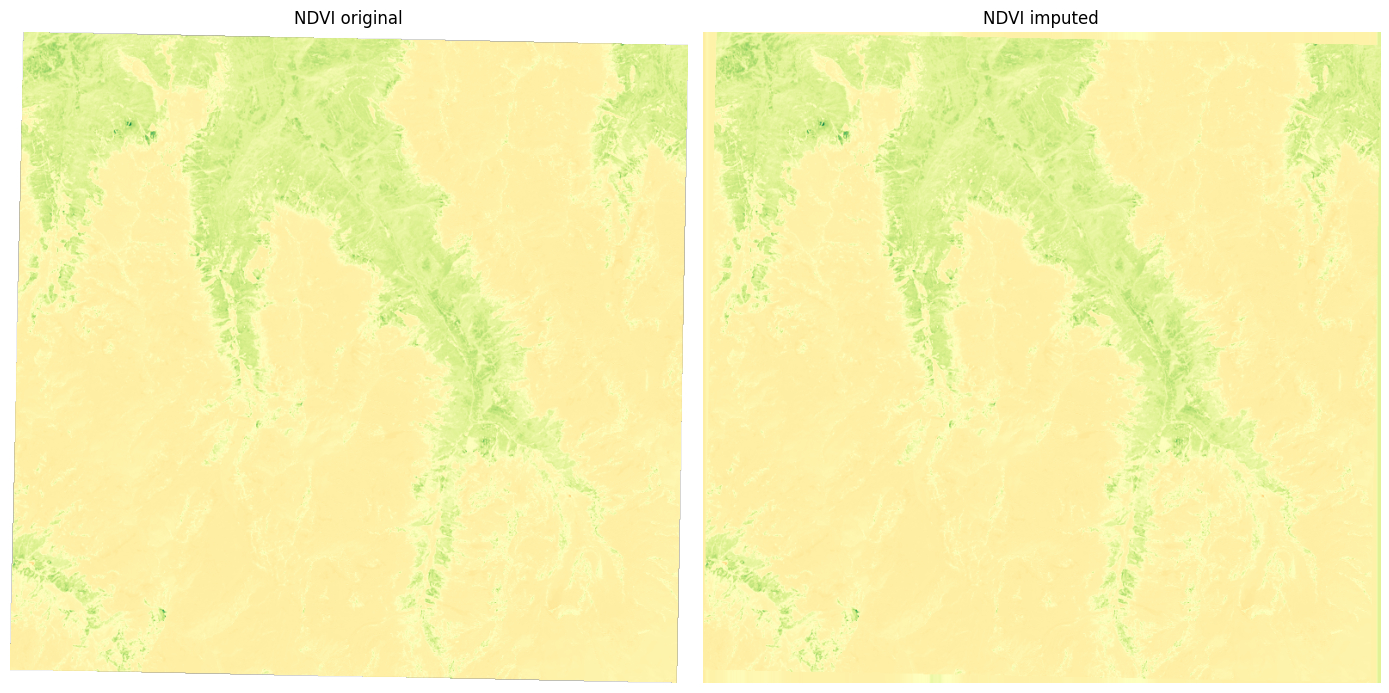

In [24]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        #if nodata is not None:
            #ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2013-04-18.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/NDVI_2013-04-18.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

vmin, vmax = -1, 1  # plage NDVI classique

axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI original')
axes[0].axis('off')

axes[1].imshow(ndvi_holes, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI imputed')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [29]:
import os
import rasterio
import numpy as np
from glob import glob

def create_random_holes_nodata(img, min_size=50, max_size=150, max_holes=5, nodata_val=-9999):
    img_with_holes = img.copy()
    h, w = img.shape
    for _ in range(np.random.randint(1, max_holes + 1)):
        x = np.random.randint(0, w - max_size)
        y = np.random.randint(0, h - max_size)
        dx = np.random.randint(min_size, max_size + 1)
        dy = np.random.randint(min_size, max_size + 1)
        img_with_holes[y:y+dy, x:x+dx] = nodata_val
    return img_with_holes

input_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/'
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/'
os.makedirs(output_dir, exist_ok=True)

image_paths = glob(os.path.join(input_dir, '*.tif'))
print(f"Nombre d'images à traiter : {len(image_paths)}")

success_count = 0
fail_count = 0

for path in image_paths:
    try:
        with rasterio.open(path) as src:
            img = src.read(1).astype(np.float32)
            profile = src.profile

        # Ajouter trous avec min_size et max_size
        img_with_holes = create_random_holes_nodata(img)

        # Mise à jour profil
        profile.update(
            dtype=rasterio.float32,
            nodata=profile.get('nodata', -9999),
            compress='lzw'
        )

        out_path = os.path.join(output_dir, os.path.basename(path))
        with rasterio.open(out_path, 'w', **profile) as dst:
            dst.write(img_with_holes, 1)

        print(f"✔ Image traitée et sauvegardée : {os.path.basename(path)}")
        success_count += 1

    except Exception as e:
        print(f"❌ Erreur sur {os.path.basename(path)} : {e}")
        fail_count += 1

print(f"\nTraitement terminé. {success_count} images traitées avec succès, {fail_count} erreurs.")


Nombre d'images à traiter : 72
✔ Image traitée et sauvegardée : NDVI_2013-04-18.tif
✔ Image traitée et sauvegardée : NDVI_2013-09-25.tif
✔ Image traitée et sauvegardée : NDVI_2013-11-12.tif
✔ Image traitée et sauvegardée : NDVI_2013-12-30.tif
✔ Image traitée et sauvegardée : NDVI_2014-08-27.tif
✔ Image traitée et sauvegardée : NDVI_2014-03-20.tif
✔ Image traitée et sauvegardée : NDVI_2014-09-12.tif
✔ Image traitée et sauvegardée : NDVI_2014-09-28.tif
✔ Image traitée et sauvegardée : NDVI_2013-11-28.tif
✔ Image traitée et sauvegardée : NDVI_2015-01-02.tif
✔ Image traitée et sauvegardée : NDVI_2015-02-19.tif
✔ Image traitée et sauvegardée : NDVI_2015-02-03.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-08.tif
✔ Image traitée et sauvegardée : NDVI_2015-03-23.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-24.tif
✔ Image traitée et sauvegardée : NDVI_2015-08-30.tif
✔ Image traitée et sauvegardée : NDVI_2015-12-20.tif
✔ Image traitée et sauvegardée : NDVI_2015-11-18.tif
✔ Image traitée

In [30]:
import rasterio

with rasterio.open('/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2023-08-20.tif') as src:
    width = src.width      # nombre de colonnes (pixels en X)
    height = src.height    # nombre de lignes (pixels en Y)
    print(f"Taille de l'image : {width} x {height} pixels")


Taille de l'image : 788 x 757 pixels


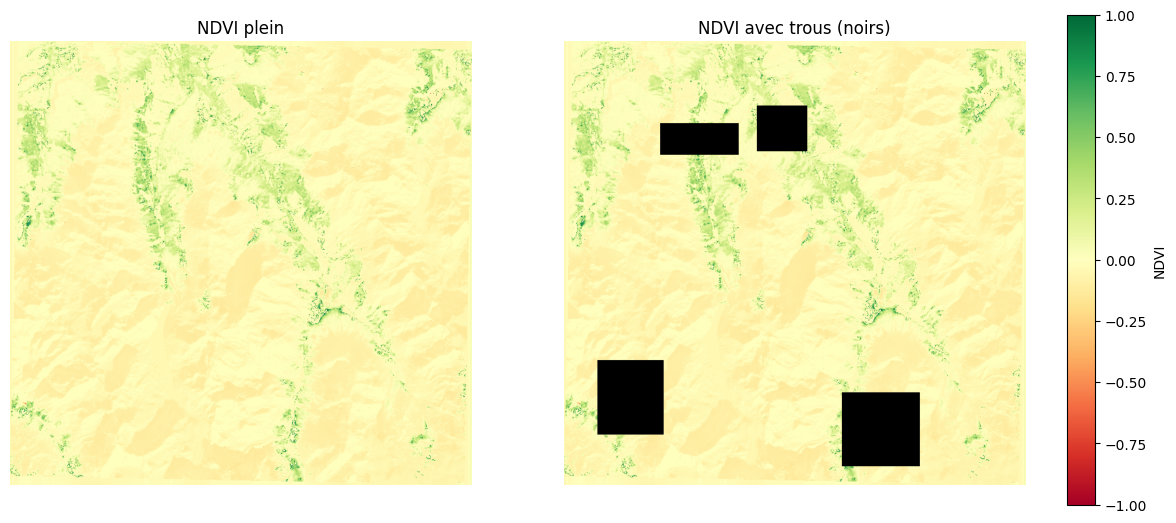

In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None:
            ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/NDVI_2016-01-21.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/NDVI_2016-01-21.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Supposons que ndvi_holes contient des NaN ou -99999
# On les masque pour les afficher en noir
masked_ndvi = np.ma.masked_where(np.isnan(ndvi_holes) | (ndvi_holes == -9999), ndvi_holes)

# Créer une copie de la colormap et définir les valeurs masquées en noir
cmap = plt.cm.RdYlGn.copy()
cmap.set_bad(color='black')  # couleur pour NaN ou valeurs masquées

vmin, vmax = -1, 1

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Image NDVI plein
axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI plein')
axes[0].axis('off')

# Image NDVI avec trous (affichés en noir)
im1 = axes[1].imshow(masked_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI avec trous (noirs)')
axes[1].axis('off')

# Colorbar à droite
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label="NDVI")

plt.show()

